## Trajectory Generation

This notebook contains scripts I was using to test agents with different movement patterns.
All of the movement generators will eventually be consolidated into one file.


In [1]:
import os
from predictive_coding.src.agent_scripts.generator_random_headdir import EnvironmentGenerator

# load the environment
home_dir = str(Path.home())
os.environ["MALMO_XSD_PATH"] = f"{home_dir}/malmo/Schemas"
environment = EnvironmentGenerator(f"{home_dir}/malmo/environments/natural.xml", 10000)


Here, we wanted to understand if model performance could be tied to variables like how predictable the trajectory is, or how far away the agent moves from its original starting point. The coefficient variables modulate this -- higher values indicate more "random" behavior. At lower coefficients, the agent's movement will generally follow a straight line, unless it needs to make smooth turns to avoid obstables. In the head-fixed models, the viewing angle will always be the same as the movement direction. In non-head-fixed models, its head will swivel back and forth sinusoidally. With an increased head_coeff, the head will make increasingly random movements.

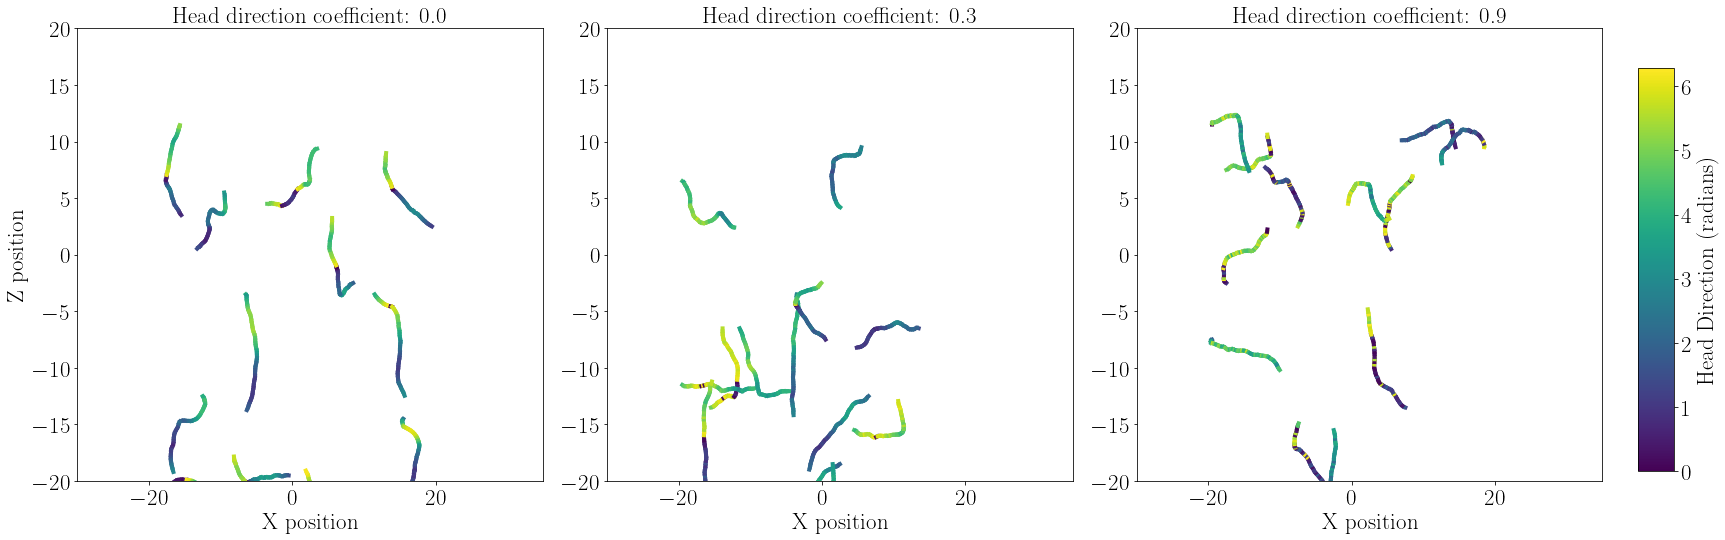

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

momentum_coeff = 0.1
dir_inertia_coeff = 0.1
head_coeffs = [0.0, 0.3, 0.9]

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# Define the colormap
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=2*np.pi)  # Normalizing from 0 to 2π radians

for idx, head_coeff in enumerate(head_coeffs):
    ax = axes[idx]
    
    for _ in range(20): 
        v, ang_v, head_ang_v, pos, move_dir, head_dir, yaw = environment.generate_path(
            momentum_coeff=momentum_coeff, 
            dir_inertia_coeff=dir_inertia_coeff,
            head_coeff=head_coeff
        )
        
        # Convert yaw from degrees to positive degrees and then to radians
        yaw = np.where(yaw < 0, yaw + 360, yaw)  # Make all yaw values positive
        yaw = np.radians(yaw)  # Convert degrees to radians
        
        # Plot each segment with a color according to the head direction
        for i in range(len(pos)-1):
            ax.plot(pos[i:i+2, 0], pos[i:i+2, 1], color=cmap(norm(yaw[i])), linewidth=4)
    
    ax.set_ylim(-20, 20)
    ax.set_xlim(-30, 35)
    ax.set_title(f'Head direction coefficient: {head_coeff}', fontsize=23)
    ax.set_xlabel('X position', fontsize=23)
    
    # Only set ylabel for the leftmost plot
    if idx == 0:
        ax.set_ylabel('Z position', fontsize=23)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=23)

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Head Direction (radians)', fontsize=23)
cbar.ax.tick_params(labelsize=23)

plt.savefig(f'traj-example-{momentum_coeff}-{dir_inertia_coeff}-multiple.png', dpi=300, bbox_inches='tight')
plt.show()

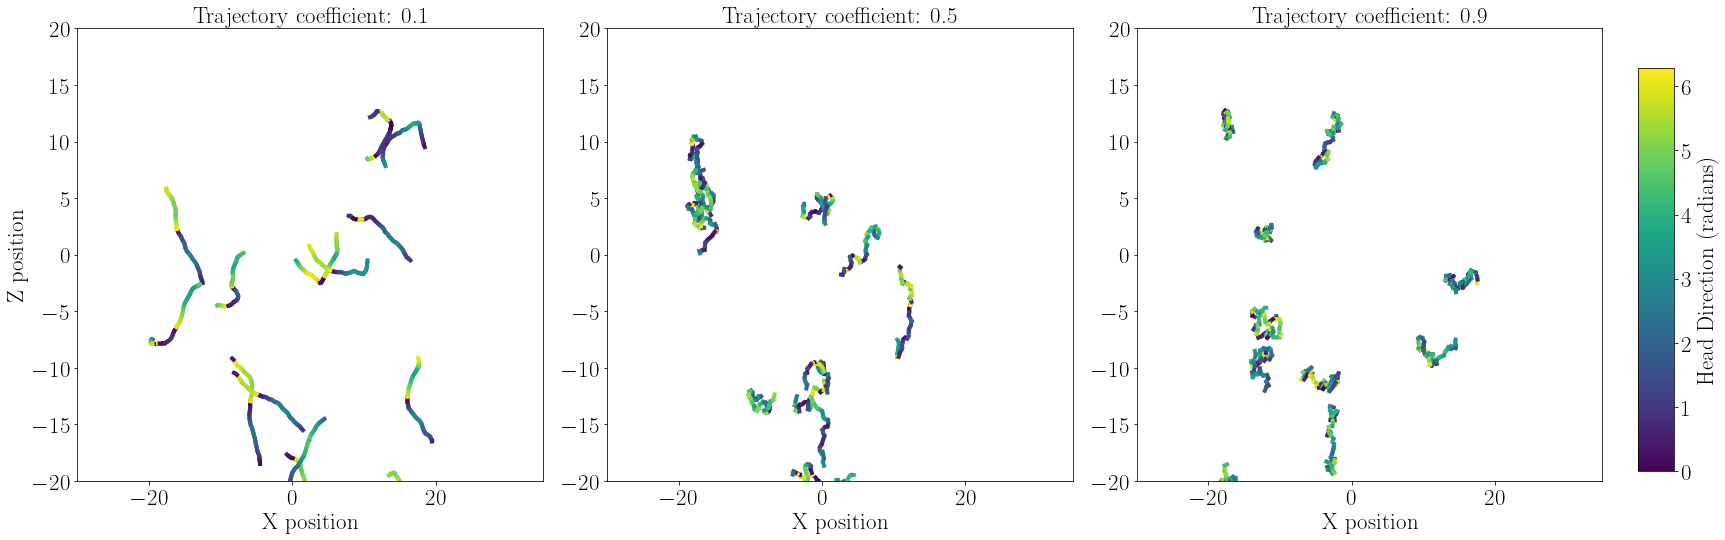

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

head_coeff = 0.0
coeff_values = [0.1, 0.5, 0.9]

# Set the global font size
plt.rcParams.update({'font.size': 23})

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# Define the colormap
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=2*np.pi)  # Normalizing from 0 to 2π radians

for idx, coeff in enumerate(coeff_values):
    ax = axes[idx]
    momentum_coeff = coeff
    dir_inertia_coeff = coeff
    
    for _ in range(20): 
        v, ang_v, head_ang_v, pos, move_dir, head_dir, yaw = environment.generate_path(
            momentum_coeff=momentum_coeff, 
            dir_inertia_coeff=dir_inertia_coeff,
            head_coeff=None
        )
        
        # Convert yaw from degrees to positive degrees and then to radians
        yaw = np.where(yaw < 0, yaw + 360, yaw)  # Make all yaw values positive
        yaw = np.radians(yaw)  # Convert degrees to radians
        
        # Plot each segment with a color according to the head direction
        for i in range(len(pos)-1):
            ax.plot(pos[i:i+2, 0], pos[i:i+2, 1], color=cmap(norm(yaw[i])), linewidth=4)
    
    ax.set_ylim(-20, 20)
    ax.set_xlim(-30, 35)
    ax.set_title(f'Trajectory coefficient: {coeff:.1f}', fontsize=23)
    ax.set_xlabel('X position', fontsize=23)
    
    # Only set ylabel for the leftmost plot
    if idx == 0:
        ax.set_ylabel('Z position', fontsize=23)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=23)

# Adjust layout to make room for the colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.9)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Head Direction (radians)', fontsize=23)
cbar.ax.tick_params(labelsize=23)

plt.savefig(f'traj-example-varying-coeffs-head-{head_coeff}.png', dpi=300, bbox_inches='tight')
plt.show()

We can also take a look at the observations gathered on these trajectories. These sequences are what's fed to the model.

In [ ]:
# generate a sequence of images from the agent's traversal
batches = []

for i in range(20):
    batch = next(iter(environment))
    batches.append(batch)
    

In [7]:
import matplotlib.pyplot as plt
import imageio

# Get the path to the FFmpeg binary installed by imageio
ffmpeg_path = imageio.plugins.ffmpeg.get_exe()

# Set Matplotlib to use this FFmpeg binary
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path

print("Configured FFmpeg path:", ffmpeg_path)


Configured FFmpeg path: /home/mag/miniconda3/envs/malmo/lib/python3.6/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux64-v4.2.2


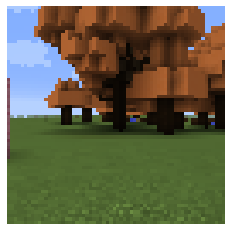

In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()

# visualize the agent's traversal
ims = []
for i in range(50):
    im = ax.imshow(batches[0][0][i], animated=True)
    ax.axis("off")
    if i == 0:
        ax.imshow(batches[0][0][0])  # show an initial one first
        ax.axis("off")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
#ani.save('really-random-trajectory.mp4', writer='ffmpeg', fps=30)
HTML(ani.to_html5_video())
